# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) [github link](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py). We refer to this VAE as the "Example VAE" in this notebook.

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


thingi = Thingi10k.init10k(pctile=.9)
# apply filter
#thingi.filter_by_id(1351747)
thingi.filter_by_tag('animal')
#thingi.filter_to_just_one()
#thingi = Thingi10k.init10()
#thingi = Thingi10k.init10(pctile=.1)
n_input = len(thingi)
n_input

154

In [3]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, debug=False, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.debug = debug
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        # add ops to this list as a tuple with (<op name>, <op>) to see them executed, returned, and printed
        # to console during execution
        self._debug_ops = list()
        
        # Construct the TensorFlow Graph
        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        self.loss, self.optimizer, self.mean_recon, self.mean_kl = self._make_loss(self._input_x, self.decoder, self.enc_mu, self.enc_sig)

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons_pre = list()
        self.recons_post = list()
        self.losses_kl_div = list()
        self.losses_recon = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
            # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
            # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
            conv1 = tf.layers.batch_normalization(tf.layers.conv3d(input_x,
                                     filters=8,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv1)
            # the Example VAE specifies the activation functions as part of the layer
            # we specify the activation function as a seperate tensor
            # it is unknown if this is the preferred method in Tensorflow, but we know
            # it works from work in the 3D-VAE-GAN notebook
            # we also take advantage of batch_normalization
            # more info here:
            # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
            # with the hope that it gives speed without sacrificing quality
            # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
            # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu

            conv2 = tf.layers.batch_normalization(tf.layers.conv3d(conv1,
                                     filters=16,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv2)

            conv3 = tf.layers.batch_normalization(tf.layers.conv3d(conv2,
                                     filters=32,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv3)

            conv4 = tf.layers.batch_normalization(tf.layers.conv3d(conv3,
                                     filters=64,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv4)

            # Apply one fully-connected layer after Conv3d layers
            # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
            dense1 = tf.layers.batch_normalization(tf.layers.dense(conv4,
                                 units=343,
                                 activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(dense1)
            flatten = tf.layers.flatten(tf.nn.dropout(dense1, keep_prob))
        
            enc_mu = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_mu)
            enc_sig = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_sig)
                                                  
            # epsilon is a random draw from the latent space
            epsilon = tf.random_normal(tf.stack([tf.shape(dense1)[0], self.latent_dim]))
            self._print_shape(epsilon, 'epsilon')
            enc_z = enc_mu + tf.multiply(epsilon, tf.exp(enc_sig))
            self._print_shape(enc_z, 'z')
        return enc_z, enc_mu, enc_sig


        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')

        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')

        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu5,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        #decoded_output = tf.nn.tanh(conv5)
        decoded_output = tf.nn.sigmoid(conv5)
        #decoded_output = tf.clip_by_value(decoded_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max decoded_output', tf.math.reduce_max(decoded_output), False)
        #self._add_debug_op('min decoded_output', tf.math.reduce_min(decoded_output), False)
        #self._add_debug_op('mean decoded_output', tf.math.reduce_mean(decoded_output), False)
        #decoded_output = conv5
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        # we must clip because values of 0 or 1 will cause errors
        #clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        clipped_input = tf.clip_by_value(enc_input, 1e-7, 1.0 - 1e-7)
        clipped_output = tf.clip_by_value(dec_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max clipped_input', tf.math.reduce_max(clipped_input), False)
        #self._add_debug_op('min clipped_input', tf.math.reduce_min(clipped_input), False)
        #self._add_debug_op('mean clipped_input', tf.math.reduce_mean(clipped_input), False)
        self._add_debug_op('max clipped_output', tf.math.reduce_max(clipped_output), False)
        self._add_debug_op('min clipped_output', tf.math.reduce_min(clipped_output), False)
        self._add_debug_op('mean clipped_output', tf.math.reduce_mean(clipped_output), False)
        bce = -(98.0 * clipped_input * tf.log(clipped_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - clipped_output)) / 100.0
        #self._add_debug_op('bce', bce, False)
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce, 1)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_kl = tf.reduce_sum(kl_divergence)
        #self._add_debug_op('mean_kl', mean_kl, False)
        mean_recon = tf.reduce_sum(recon_loss)
        #self._add_debug_op('mean_recon', mean_recon, False)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        #self._add_debug_op('loss', loss, False)
        # remove kl for fun
        #loss = tf.reduce_mean(self.recon_loss_weight * recon_loss)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

        return loss, optimizer, mean_recon, mean_kl

    def _add_debug_op(self, name, op, newline=True):
        self._debug_ops.append((name, op, newline))
        return

    def _print_debug_ops(self, results):
        if self.debug:
            for i, debug_op in enumerate(self._debug_ops):
                msg = 'DEBUG_OP "{}": '.format(debug_op[0])
                if len(debug_op) > 2 and debug_op[2]:
                    msg += '\n'
                msg += '{}'.format(results[i])
                print(msg)
        return

    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

                    ops = tuple([self.optimizer, self.loss, self.mean_kl, self.mean_recon] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    _, loss, kl_divergence, recon_loss = results[:4]
                    self._print_debug_ops(results[4:])
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\tKL Divergence = {}, Reconstruction Loss = {}'.format(kl_divergence, recon_loss))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                if viz_data is None:
                    viz_data = batch[0]
                self._print_shape(viz_data, 'Example shape (before reshape)')
                recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
                self._print_shape(recon_input, 'Example shape')
                
                # generate!
                recon = self.reconstruct(recon_input)
                self._print_shape(recon, 'Recon')

                # prepare for plotting
                recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon_input, 'Example shape (for plotting)')
                recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon, 'Recon (for plotting)')
                # network outputs decimals; here we force them to True/False for plotting
                self.recons_pre.append(recon)
                recon = recon > 0.5
                self.recons_post.append(recon)
                # replace all nans with zeros
                #recon = np.nan_to_num(recon)
                
                # save the generated object in case we wish to review later
                path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

                # visualize
                self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.decoder] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        
        decoded = results[0]
        self._print_debug_ops(results[1:])
                    
        return decoded
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon
* Equalized loss weights yielded no change (at 100 epochs on one square example with 50 input_repeats, viz was all 1s)
* By dumping out counts of True vs False of each recon, I can see that False goes down while True goes up to the point where they are almost all Trues after 50 epochs
* Run through all training examples produces loss of nan
* Added homebaked debug_ops and discovered that the dec_output is nan and not the loss functions!

Num input = 154
Num batches per epoch = 7.00


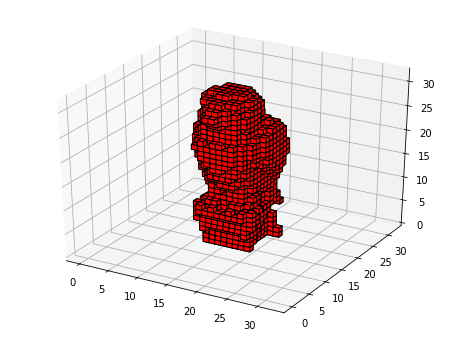

In [4]:
VOXELS_DIM = 32
BATCH_SIZE = 22
print('Num input = {}'.format(n_input))
print('Num batches per epoch = {:.2f}'.format(n_input / BATCH_SIZE))
training_example = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=126660))
plot_voxels(training_example)

encoder/batch_normalization/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_6/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
dec_dense1/BiasAdd:0: (?, 343)
Elu:0: (?, 343)
reshape_z:0: (?, 7, 7, 7, 1)
dec_conv1/conv3d_transpose:0: (?, 7, 7, 7, 64)
dec_lrelu2:0: (?, 7, 7, 7, 64)
dec_conv2/conv3d_transpose:0: (?, 15, 15, 15, 32)
dec_lrelu3:0: (?, 15, 15, 15, 32)
dec_conv3/conv3d_transpose:0: (?, 15, 15, 15, 16)
dec_lrelu4:0: (?, 15, 15, 15, 16)
dec_conv4/conv3d_transpose:0: (?, 32, 32, 32, 8)
dec_lrelu5:0: (?, 32, 32, 32, 8)
dec_conv5/conv3d_transpose:0: (?, 32, 32, 32, 1)
Sigmoid:0: (?, 32, 32, 32, 1)
Epoch: 0, Batch:

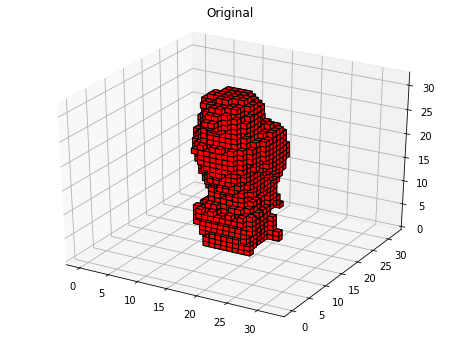

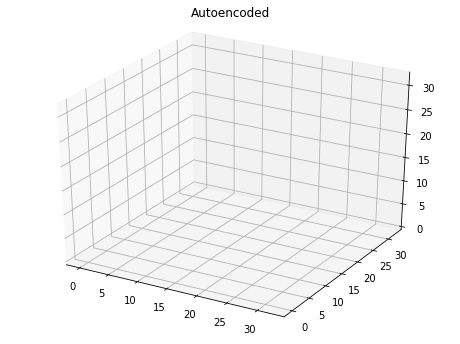

Epoch: 1, Batch: 0, Elapsed time: 0.14 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 0.09975872933864594
DEBUG_OP "mean clipped_output": 0.7409802079200745
DEBUG_OP "mean_kl": 405.66748046875
DEBUG_OP "mean_recon": 949.3333129882812
DEBUG_OP "loss": 439.84112548828125
	KL Divergence = 405.66748046875, Reconstruction Loss = 949.3333129882812
Epoch: 1, Batch: 1, Elapsed time: 0.15 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999959468841553
DEBUG_OP "min clipped_output": 0.05060102045536041
DEBUG_OP "mean clipped_output": 0.675745964050293
DEBUG_OP "mean_kl": 111.67205047607422
DEBUG_OP "mean_recon": 945.7940673828125
DEBUG_OP "loss": 424.9051818847656
	

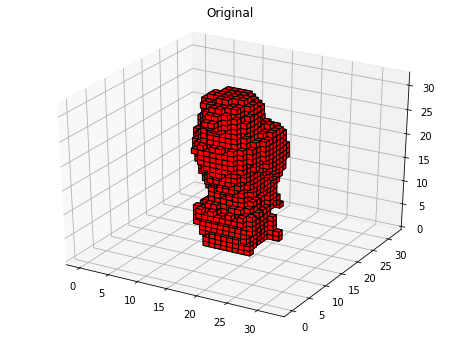

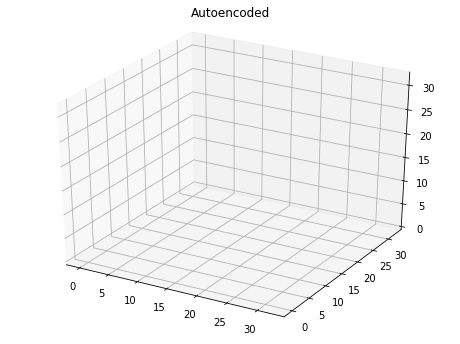

Epoch: 2, Batch: 0, Elapsed time: 0.27 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.999996542930603
DEBUG_OP "min clipped_output": 0.07567504793405533
DEBUG_OP "mean clipped_output": 0.6762667894363403
DEBUG_OP "mean_kl": 160.6056365966797
DEBUG_OP "mean_recon": 888.9371948242188
DEBUG_OP "loss": 401.8923034667969
	KL Divergence = 160.6056365966797, Reconstruction Loss = 888.9371948242188
Epoch: 2, Batch: 1, Elapsed time: 0.28 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999984502792358
DEBUG_OP "min clipped_output": 0.08520667254924774
DEBUG_OP "mean clipped_output": 0.6596623063087463
DEBUG_OP "mean_kl": 220.3603515625
DEBUG_OP "mean_recon": 938.3267822265625
DEBUG_OP "loss": 426.53271484375
	KL 

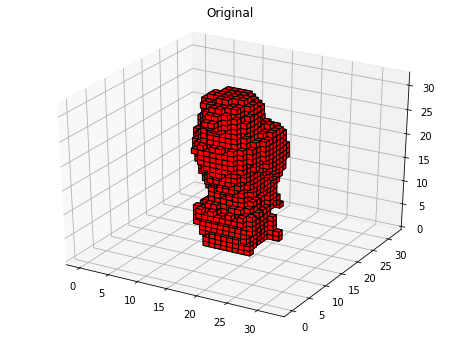

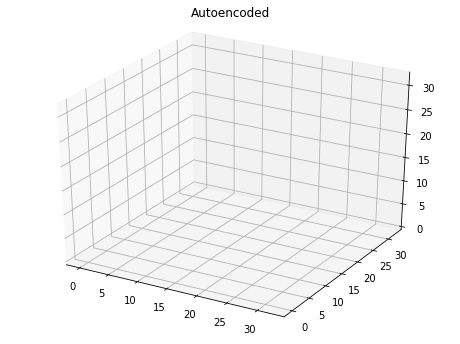

Epoch: 3, Batch: 0, Elapsed time: 0.40 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999877214431763
DEBUG_OP "min clipped_output": 0.04809780791401863
DEBUG_OP "mean clipped_output": 0.6360322833061218
DEBUG_OP "mean_kl": 122.25653076171875
DEBUG_OP "mean_recon": 833.9788208007812
DEBUG_OP "loss": 375.7530212402344
	KL Divergence = 122.25653076171875, Reconstruction Loss = 833.9788208007812
Epoch: 3, Batch: 1, Elapsed time: 0.42 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.999972939491272
DEBUG_OP "min clipped_output": 0.039168890565633774
DEBUG_OP "mean clipped_output": 0.6270074248313904
DEBUG_OP "mean_kl": 127.58624267578125
DEBUG_OP "mean_recon": 890.7182006835938
DEBUG_OP "loss": 401.182495117

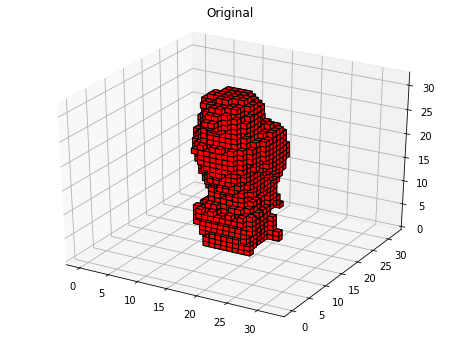

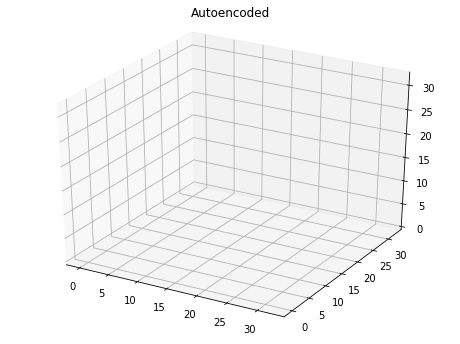

Epoch: 4, Batch: 0, Elapsed time: 0.54 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999892711639404
DEBUG_OP "min clipped_output": 0.06622819602489471
DEBUG_OP "mean clipped_output": 0.6292375922203064
DEBUG_OP "mean_kl": 204.69723510742188
DEBUG_OP "mean_recon": 787.6538696289062
DEBUG_OP "loss": 358.9373779296875
	KL Divergence = 204.69723510742188, Reconstruction Loss = 787.6538696289062
Epoch: 4, Batch: 1, Elapsed time: 0.55 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999849796295166
DEBUG_OP "min clipped_output": 0.054606448858976364
DEBUG_OP "mean clipped_output": 0.6077320575714111
DEBUG_OP "mean_kl": 205.32952880859375
DEBUG_OP "mean_recon": 877.1414794921875
DEBUG_OP "loss": 398.68853759

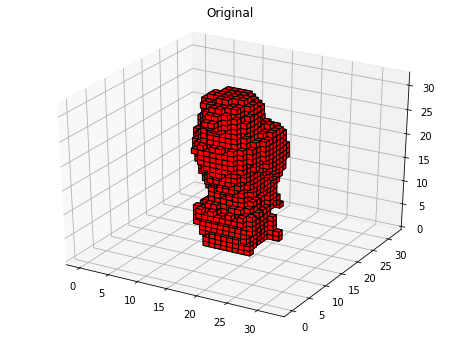

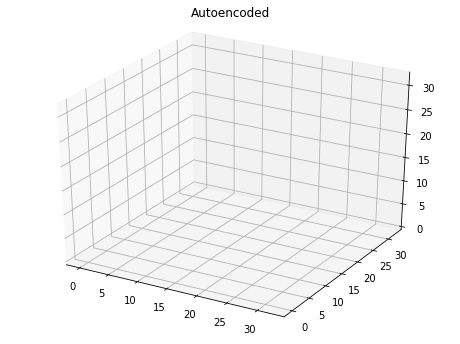

Epoch: 5, Batch: 0, Elapsed time: 0.67 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999954700469971
DEBUG_OP "min clipped_output": 0.04770735651254654
DEBUG_OP "mean clipped_output": 0.6056373119354248
DEBUG_OP "mean_kl": 393.19305419921875
DEBUG_OP "mean_recon": 725.032470703125
DEBUG_OP "loss": 339.70855712890625
	KL Divergence = 393.19305419921875, Reconstruction Loss = 725.032470703125
Epoch: 5, Batch: 1, Elapsed time: 0.68 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999991655349731
DEBUG_OP "min clipped_output": 0.030763041228055954
DEBUG_OP "mean clipped_output": 0.5710378289222717
DEBUG_OP "mean_kl": 455.47894287109375
DEBUG_OP "mean_recon": 749.8726196289062
DEBUG_OP "loss": 353.565795898

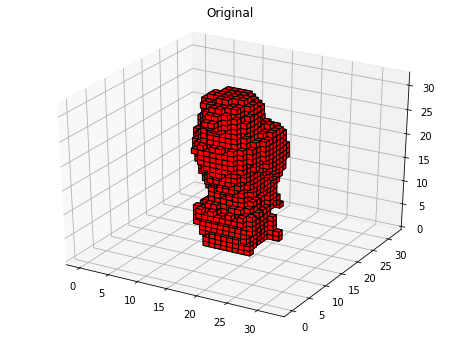

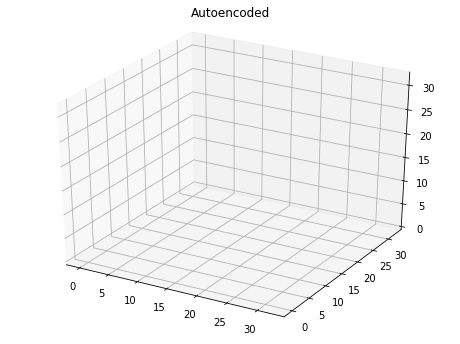

Epoch: 6, Batch: 0, Elapsed time: 0.81 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999980926513672
DEBUG_OP "min clipped_output": 0.03339436650276184
DEBUG_OP "mean clipped_output": 0.5970309972763062
DEBUG_OP "mean_kl": 547.927490234375
DEBUG_OP "mean_recon": 685.2401123046875
DEBUG_OP "loss": 329.0780029296875
	KL Divergence = 547.927490234375, Reconstruction Loss = 685.2401123046875
Epoch: 6, Batch: 1, Elapsed time: 0.82 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999897480010986
DEBUG_OP "min clipped_output": 0.02505715750157833
DEBUG_OP "mean clipped_output": 0.5740427374839783
DEBUG_OP "mean_kl": 389.70733642578125
DEBUG_OP "mean_recon": 759.1297607421875
DEBUG_OP "loss": 354.6860046386719

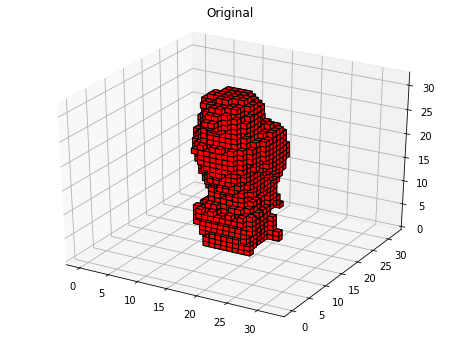

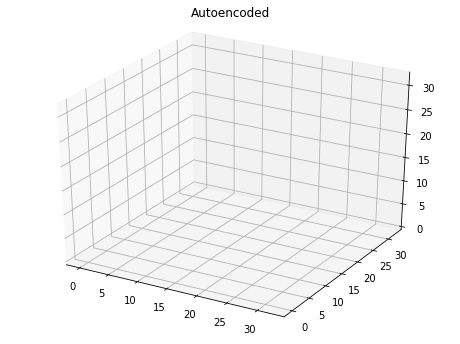

Epoch: 7, Batch: 0, Elapsed time: 0.94 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999686479568481
DEBUG_OP "min clipped_output": 0.018422264605760574
DEBUG_OP "mean clipped_output": 0.5637436509132385
DEBUG_OP "mean_kl": 558.7051391601562
DEBUG_OP "mean_recon": 616.0618896484375
DEBUG_OP "loss": 298.8608703613281
	KL Divergence = 558.7051391601562, Reconstruction Loss = 616.0618896484375
Epoch: 7, Batch: 1, Elapsed time: 0.95 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.999962568283081
DEBUG_OP "min clipped_output": 0.015448656864464283
DEBUG_OP "mean clipped_output": 0.5353798270225525
DEBUG_OP "mean_kl": 472.1891784667969
DEBUG_OP "mean_recon": 675.0794067382812
DEBUG_OP "loss": 321.12551879882

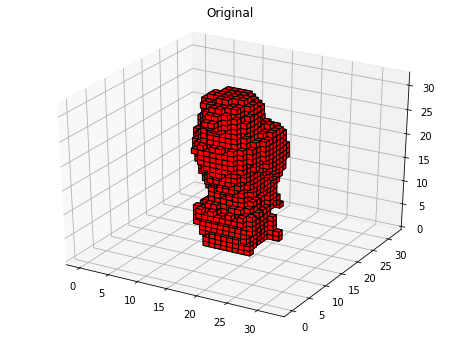

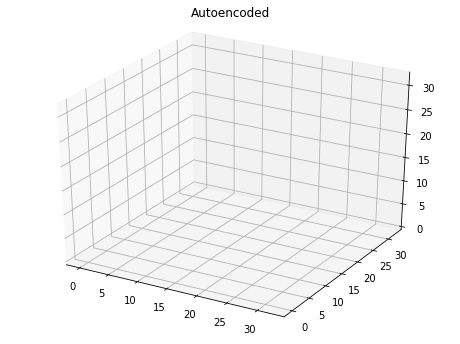

Epoch: 8, Batch: 0, Elapsed time: 1.07 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.999895453453064
DEBUG_OP "min clipped_output": 0.005399601999670267
DEBUG_OP "mean clipped_output": 0.5215297341346741
DEBUG_OP "mean_kl": 736.9774780273438
DEBUG_OP "mean_recon": 576.5142211914062
DEBUG_OP "loss": 289.4089660644531
	KL Divergence = 736.9774780273438, Reconstruction Loss = 576.5142211914062
Epoch: 8, Batch: 1, Elapsed time: 1.09 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999852180480957
DEBUG_OP "min clipped_output": 0.003122873604297638
DEBUG_OP "mean clipped_output": 0.5050281882286072
DEBUG_OP "mean_kl": 652.911865234375
DEBUG_OP "mean_recon": 643.2681884765625
DEBUG_OP "loss": 315.219146728515

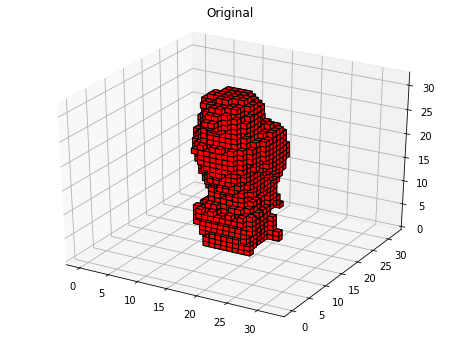

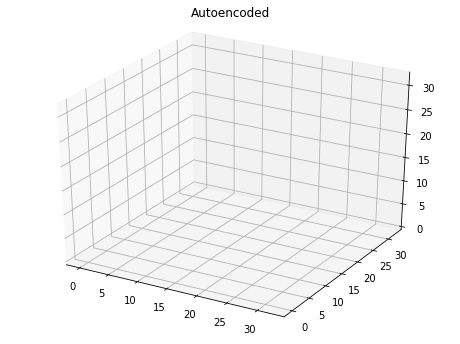

Epoch: 9, Batch: 0, Elapsed time: 1.21 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998801946640015
DEBUG_OP "min clipped_output": 0.003433678997680545
DEBUG_OP "mean clipped_output": 0.5021823644638062
DEBUG_OP "mean_kl": 772.3208618164062
DEBUG_OP "mean_recon": 554.9086303710938
DEBUG_OP "loss": 281.42529296875
	KL Divergence = 772.3208618164062, Reconstruction Loss = 554.9086303710938
Epoch: 9, Batch: 1, Elapsed time: 1.22 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999514818191528
DEBUG_OP "min clipped_output": 0.0022565810941159725
DEBUG_OP "mean clipped_output": 0.4920649826526642
DEBUG_OP "mean_kl": 747.255615234375
DEBUG_OP "mean_recon": 589.4024047851562
DEBUG_OP "loss": 295.597045898437

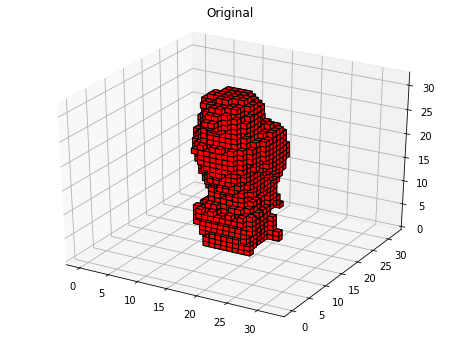

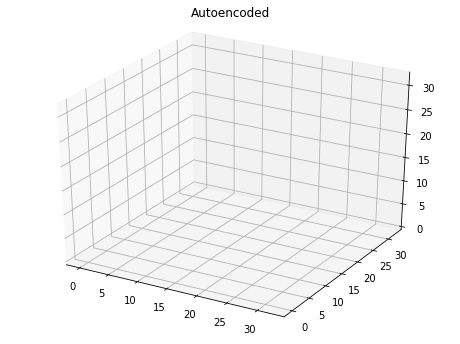

Epoch: 10, Batch: 0, Elapsed time: 1.34 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.999870777130127
DEBUG_OP "min clipped_output": 0.002137141302227974
DEBUG_OP "mean clipped_output": 0.47507140040397644
DEBUG_OP "mean_kl": 647.329833984375
DEBUG_OP "mean_recon": 538.4098510742188
DEBUG_OP "loss": 268.4203796386719
	KL Divergence = 647.329833984375, Reconstruction Loss = 538.4098510742188
Epoch: 10, Batch: 1, Elapsed time: 1.35 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999333620071411
DEBUG_OP "min clipped_output": 0.001581497141160071
DEBUG_OP "mean clipped_output": 0.46838170289993286
DEBUG_OP "mean_kl": 717.7854614257812
DEBUG_OP "mean_recon": 561.91552734375
DEBUG_OP "loss": 282.05661010742

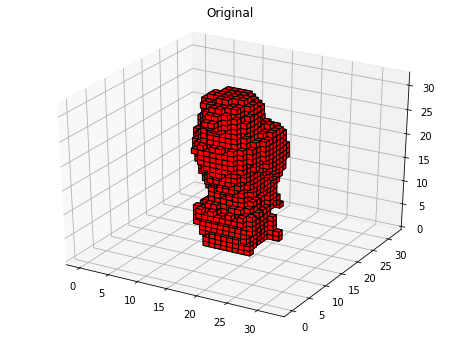

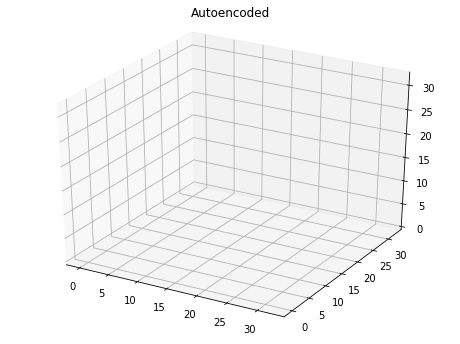

Epoch: 11, Batch: 0, Elapsed time: 1.47 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9997914433479309
DEBUG_OP "min clipped_output": 0.0006295254570432007
DEBUG_OP "mean clipped_output": 0.4541073739528656
DEBUG_OP "mean_kl": 680.212158203125
DEBUG_OP "mean_recon": 515.371826171875
DEBUG_OP "loss": 259.6882019042969
	KL Divergence = 680.212158203125, Reconstruction Loss = 515.371826171875
Epoch: 11, Batch: 1, Elapsed time: 1.49 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999741315841675
DEBUG_OP "min clipped_output": 0.0011552348732948303
DEBUG_OP "mean clipped_output": 0.4494742155075073
DEBUG_OP "mean_kl": 779.6690673828125
DEBUG_OP "mean_recon": 548.723876953125
DEBUG_OP "loss": 279.01354980468

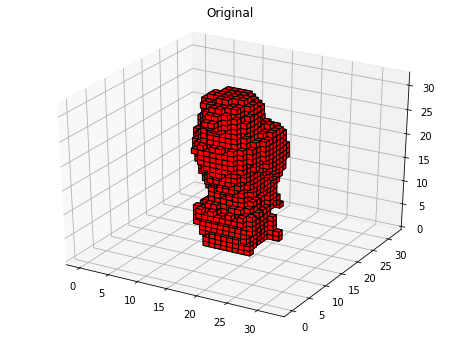

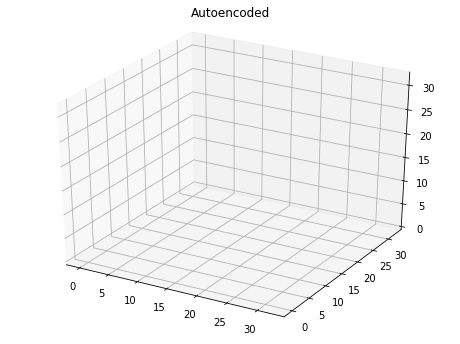

Epoch: 12, Batch: 0, Elapsed time: 1.61 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999207258224487
DEBUG_OP "min clipped_output": 0.0005034243804402649
DEBUG_OP "mean clipped_output": 0.4314393997192383
DEBUG_OP "mean_kl": 814.64453125
DEBUG_OP "mean_recon": 466.58447265625
DEBUG_OP "loss": 244.1422882080078
	KL Divergence = 814.64453125, Reconstruction Loss = 466.58447265625
Epoch: 12, Batch: 1, Elapsed time: 1.62 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999321699142456
DEBUG_OP "min clipped_output": 0.00044265500036999583
DEBUG_OP "mean clipped_output": 0.4242710769176483
DEBUG_OP "mean_kl": 779.34765625
DEBUG_OP "mean_recon": 497.1230773925781
DEBUG_OP "loss": 256.0938415527344
	KL Diverg

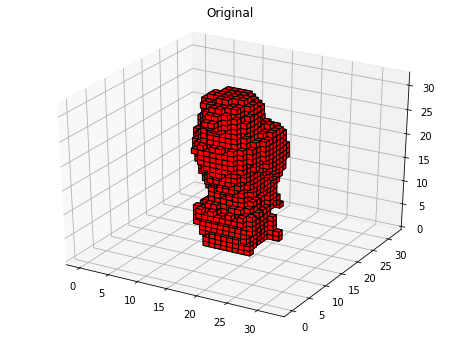

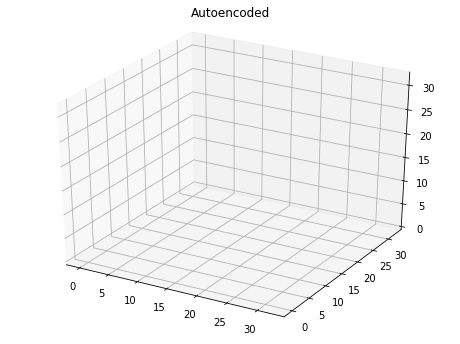

Epoch: 13, Batch: 0, Elapsed time: 1.74 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998552799224854
DEBUG_OP "min clipped_output": 0.00045176001731306314
DEBUG_OP "mean clipped_output": 0.42352545261383057
DEBUG_OP "mean_kl": 957.530517578125
DEBUG_OP "mean_recon": 454.34600830078125
DEBUG_OP "loss": 245.2047576904297
	KL Divergence = 957.530517578125, Reconstruction Loss = 454.34600830078125
Epoch: 13, Batch: 1, Elapsed time: 1.75 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998801946640015
DEBUG_OP "min clipped_output": 0.0005755397141911089
DEBUG_OP "mean clipped_output": 0.4138200879096985
DEBUG_OP "mean_kl": 868.755859375
DEBUG_OP "mean_recon": 483.8403015136719
DEBUG_OP "loss": 254.26129150

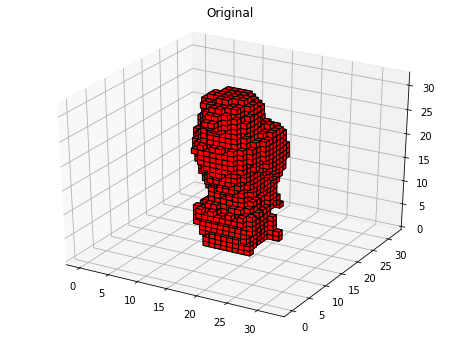

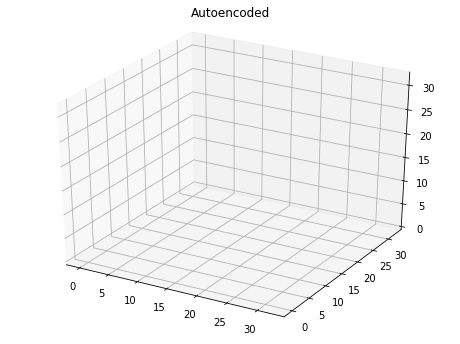

Epoch: 14, Batch: 0, Elapsed time: 1.88 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.99972003698349
DEBUG_OP "min clipped_output": 0.000488526769913733
DEBUG_OP "mean clipped_output": 0.4256764352321625
DEBUG_OP "mean_kl": 835.3152465820312
DEBUG_OP "mean_recon": 437.8680419921875
DEBUG_OP "loss": 232.3351593017578
	KL Divergence = 835.3152465820312, Reconstruction Loss = 437.8680419921875
Epoch: 14, Batch: 1, Elapsed time: 1.89 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9996993541717529
DEBUG_OP "min clipped_output": 0.0007820346509106457
DEBUG_OP "mean clipped_output": 0.41557028889656067
DEBUG_OP "mean_kl": 690.635986328125
DEBUG_OP "mean_recon": 488.21099853515625
DEBUG_OP "loss": 248.10540771

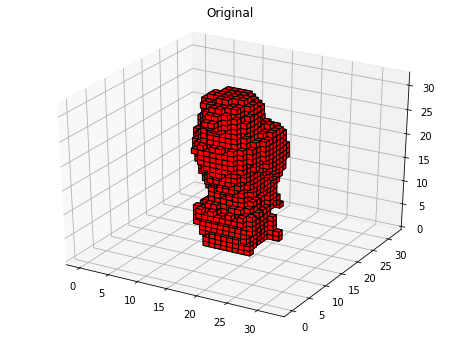

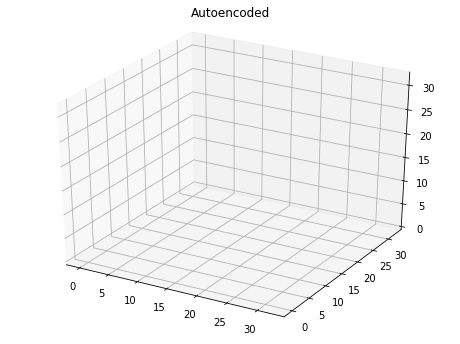

Epoch: 15, Batch: 0, Elapsed time: 2.01 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9997199177742004
DEBUG_OP "min clipped_output": 0.00043553466093726456
DEBUG_OP "mean clipped_output": 0.40532276034355164
DEBUG_OP "mean_kl": 812.8565673828125
DEBUG_OP "mean_recon": 435.62103271484375
DEBUG_OP "loss": 230.31692504882812
	KL Divergence = 812.8565673828125, Reconstruction Loss = 435.62103271484375
Epoch: 15, Batch: 1, Elapsed time: 2.03 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998069405555725
DEBUG_OP "min clipped_output": 0.0006447299383580685
DEBUG_OP "mean clipped_output": 0.3974030613899231
DEBUG_OP "mean_kl": 801.9737548828125
DEBUG_OP "mean_recon": 462.6199951171875
DEBUG_OP "loss": 241.8

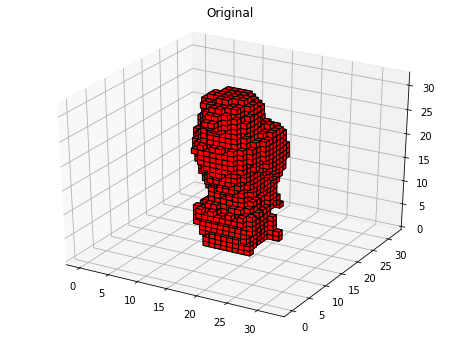

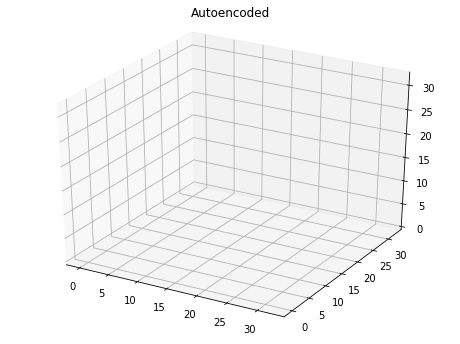

Epoch: 16, Batch: 0, Elapsed time: 2.15 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999281167984009
DEBUG_OP "min clipped_output": 0.00022339911083690822
DEBUG_OP "mean clipped_output": 0.3883914649486542
DEBUG_OP "mean_kl": 754.5966796875
DEBUG_OP "mean_recon": 422.5877380371094
DEBUG_OP "loss": 221.8828125
	KL Divergence = 754.5966796875, Reconstruction Loss = 422.5877380371094
Epoch: 16, Batch: 1, Elapsed time: 2.16 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998610019683838
DEBUG_OP "min clipped_output": 0.00017917482182383537
DEBUG_OP "mean clipped_output": 0.38198184967041016
DEBUG_OP "mean_kl": 741.0072631835938
DEBUG_OP "mean_recon": 482.31744384765625
DEBUG_OP "loss": 247.77850341796875

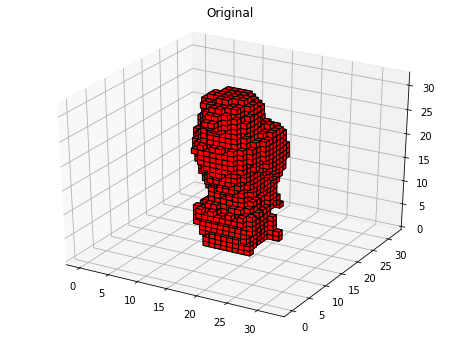

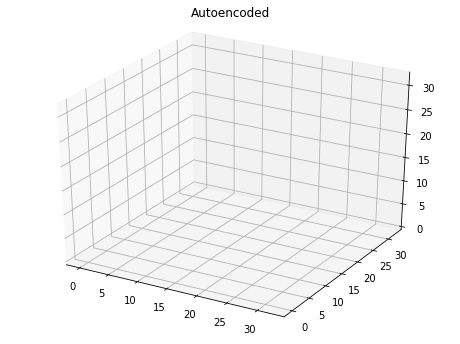

Epoch: 17, Batch: 0, Elapsed time: 2.28 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998800754547119
DEBUG_OP "min clipped_output": 0.00022986542899161577
DEBUG_OP "mean clipped_output": 0.4019608199596405
DEBUG_OP "mean_kl": 978.8233642578125
DEBUG_OP "mean_recon": 405.8206787109375
DEBUG_OP "loss": 224.63238525390625
	KL Divergence = 978.8233642578125, Reconstruction Loss = 405.8206787109375
Epoch: 17, Batch: 1, Elapsed time: 2.30 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998241066932678
DEBUG_OP "min clipped_output": 0.00018083090253639966
DEBUG_OP "mean clipped_output": 0.392348974943161
DEBUG_OP "mean_kl": 842.05419921875
DEBUG_OP "mean_recon": 432.52618408203125
DEBUG_OP "loss": 230.26943

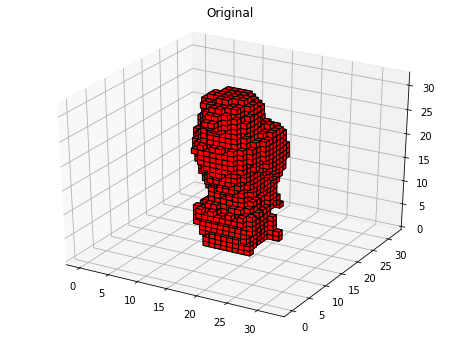

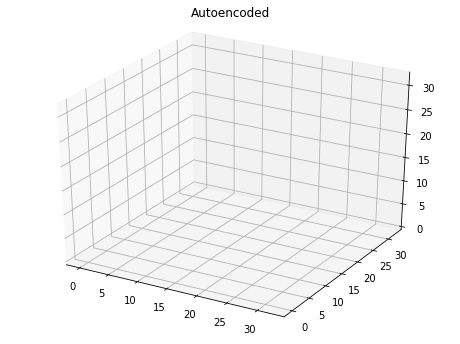

Epoch: 18, Batch: 0, Elapsed time: 2.42 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998403787612915
DEBUG_OP "min clipped_output": 0.00011418486974434927
DEBUG_OP "mean clipped_output": 0.39135825634002686
DEBUG_OP "mean_kl": 825.10791015625
DEBUG_OP "mean_recon": 409.45098876953125
DEBUG_OP "loss": 219.2577362060547
	KL Divergence = 825.10791015625, Reconstruction Loss = 409.45098876953125
Epoch: 18, Batch: 1, Elapsed time: 2.43 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9996851682662964
DEBUG_OP "min clipped_output": 0.00022602950048167259
DEBUG_OP "mean clipped_output": 0.38038700819015503
DEBUG_OP "mean_kl": 709.8448486328125
DEBUG_OP "mean_recon": 450.775390625
DEBUG_OP "loss": 232.36212158

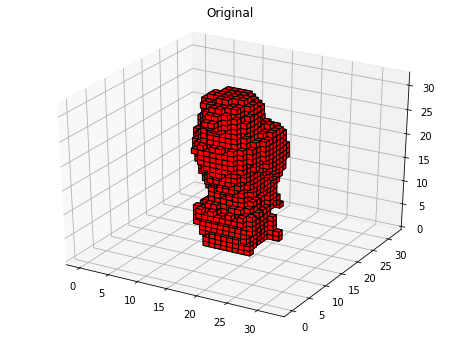

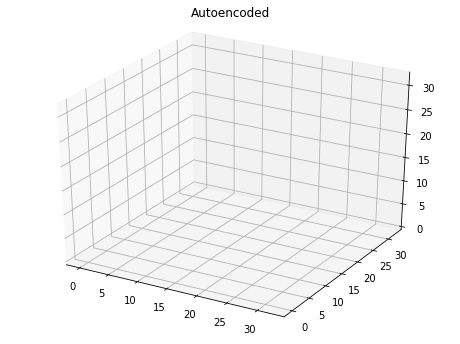

Epoch: 19, Batch: 0, Elapsed time: 2.55 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998264908790588
DEBUG_OP "min clipped_output": 0.00011220798478461802
DEBUG_OP "mean clipped_output": 0.37673136591911316
DEBUG_OP "mean_kl": 830.343505859375
DEBUG_OP "mean_recon": 421.4889831542969
DEBUG_OP "loss": 224.83871459960938
	KL Divergence = 830.343505859375, Reconstruction Loss = 421.4889831542969
Epoch: 19, Batch: 1, Elapsed time: 2.57 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9996381998062134
DEBUG_OP "min clipped_output": 0.00022226816508919
DEBUG_OP "mean clipped_output": 0.3709838092327118
DEBUG_OP "mean_kl": 817.9791259765625
DEBUG_OP "mean_recon": 431.06085205078125
DEBUG_OP "loss": 228.525756

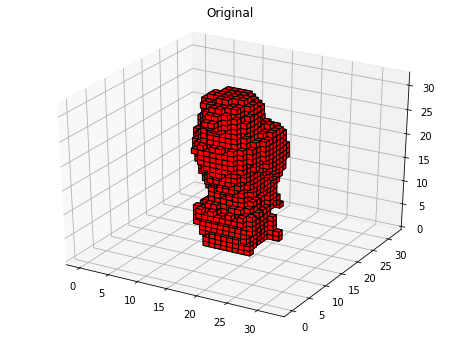

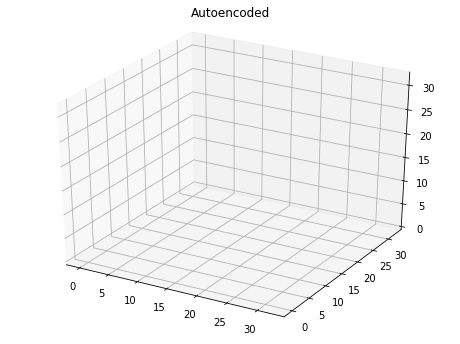

Epoch: 20, Batch: 0, Elapsed time: 2.69 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999029636383057
DEBUG_OP "min clipped_output": 9.594939911039546e-05
DEBUG_OP "mean clipped_output": 0.37771642208099365
DEBUG_OP "mean_kl": 998.1253662109375
DEBUG_OP "mean_recon": 376.24969482421875
DEBUG_OP "loss": 212.38330078125
	KL Divergence = 998.1253662109375, Reconstruction Loss = 376.24969482421875
Epoch: 20, Batch: 1, Elapsed time: 2.70 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998934268951416
DEBUG_OP "min clipped_output": 0.00012455129763111472
DEBUG_OP "mean clipped_output": 0.36294570565223694
DEBUG_OP "mean_kl": 848.9437866210938
DEBUG_OP "mean_recon": 419.72149658203125
DEBUG_OP "loss": 224.89

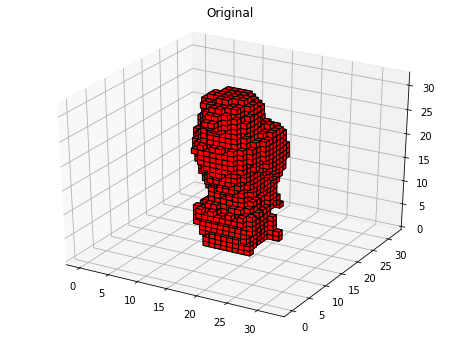

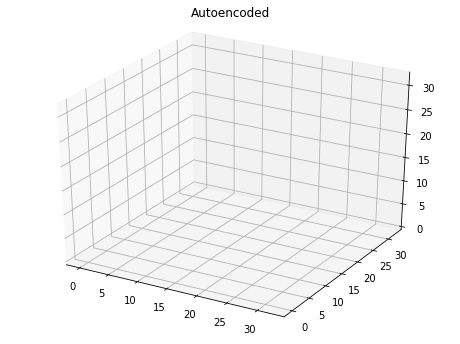

Epoch: 21, Batch: 0, Elapsed time: 2.82 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999295473098755
DEBUG_OP "min clipped_output": 5.241746475803666e-05
DEBUG_OP "mean clipped_output": 0.3611160218715668
DEBUG_OP "mean_kl": 930.8348999023438
DEBUG_OP "mean_recon": 370.46722412109375
DEBUG_OP "loss": 206.7576141357422
	KL Divergence = 930.8348999023438, Reconstruction Loss = 370.46722412109375
Epoch: 21, Batch: 1, Elapsed time: 2.83 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998401403427124
DEBUG_OP "min clipped_output": 9.633757872506976e-05
DEBUG_OP "mean clipped_output": 0.34959256649017334
DEBUG_OP "mean_kl": 769.10888671875
DEBUG_OP "mean_recon": 423.2758483886719
DEBUG_OP "loss": 222.84814

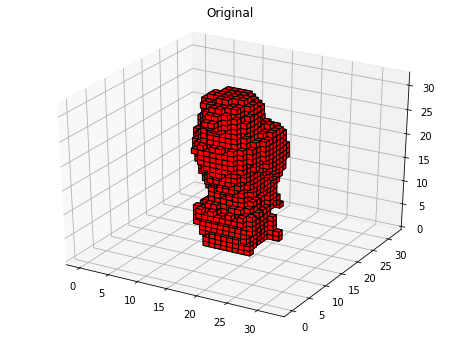

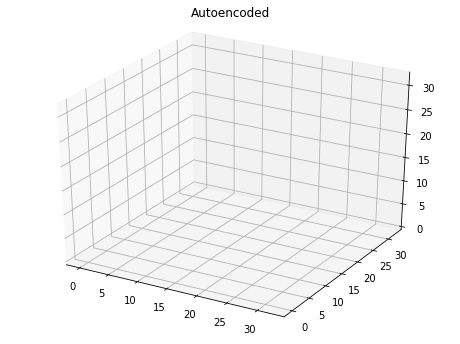

Epoch: 22, Batch: 0, Elapsed time: 2.95 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999233484268188
DEBUG_OP "min clipped_output": 5.62532659387216e-05
DEBUG_OP "mean clipped_output": 0.36365559697151184
DEBUG_OP "mean_kl": 876.0957641601562
DEBUG_OP "mean_recon": 365.9207763671875
DEBUG_OP "loss": 202.25225830078125
	KL Divergence = 876.0957641601562, Reconstruction Loss = 365.9207763671875
Epoch: 22, Batch: 1, Elapsed time: 2.96 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9997628331184387
DEBUG_OP "min clipped_output": 7.140110392356291e-05
DEBUG_OP "mean clipped_output": 0.3559528589248657
DEBUG_OP "mean_kl": 776.4576416015625
DEBUG_OP "mean_recon": 412.77301025390625
DEBUG_OP "loss": 218.5204

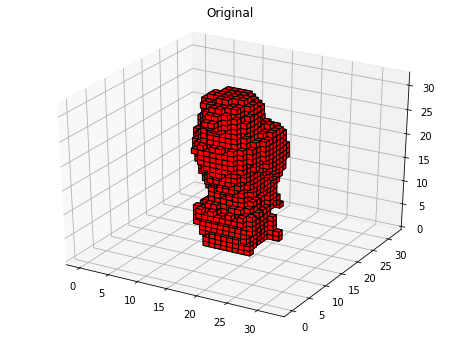

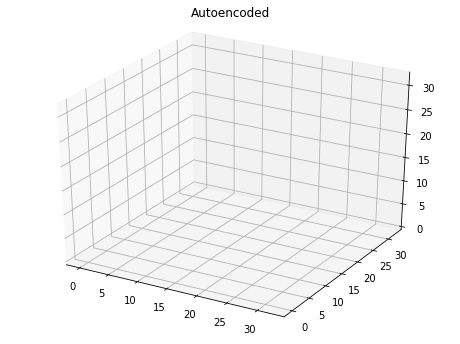

Epoch: 23, Batch: 0, Elapsed time: 3.09 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998440742492676
DEBUG_OP "min clipped_output": 6.5746353357099e-05
DEBUG_OP "mean clipped_output": 0.36734065413475037
DEBUG_OP "mean_kl": 879.1724853515625
DEBUG_OP "mean_recon": 372.14056396484375
DEBUG_OP "loss": 205.15277099609375
	KL Divergence = 879.1724853515625, Reconstruction Loss = 372.14056396484375
Epoch: 23, Batch: 1, Elapsed time: 3.10 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9997418522834778
DEBUG_OP "min clipped_output": 7.438515604007989e-05
DEBUG_OP "mean clipped_output": 0.35441917181015015
DEBUG_OP "mean_kl": 802.778564453125
DEBUG_OP "mean_recon": 400.6165771484375
DEBUG_OP "loss": 214.3201

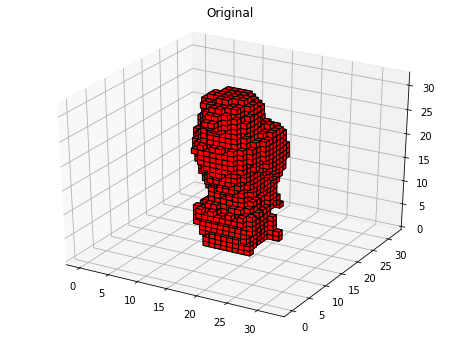

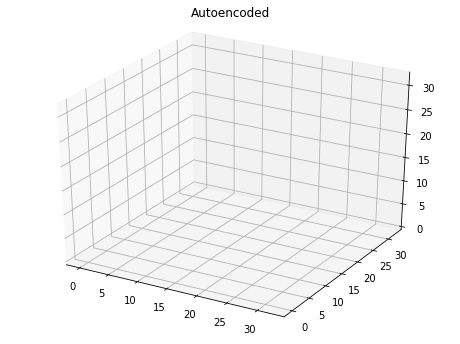

Epoch: 24, Batch: 0, Elapsed time: 3.22 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999109506607056
DEBUG_OP "min clipped_output": 2.8114940505474806e-05
DEBUG_OP "mean clipped_output": 0.3618223965167999
DEBUG_OP "mean_kl": 937.4386596679688
DEBUG_OP "mean_recon": 365.4114990234375
DEBUG_OP "loss": 204.81427001953125
	KL Divergence = 937.4386596679688, Reconstruction Loss = 365.4114990234375
Epoch: 24, Batch: 1, Elapsed time: 3.23 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999209642410278
DEBUG_OP "min clipped_output": 5.983467053738423e-05
DEBUG_OP "mean clipped_output": 0.34434089064598083
DEBUG_OP "mean_kl": 893.0086059570312
DEBUG_OP "mean_recon": 396.5534362792969
DEBUG_OP "loss": 216.618

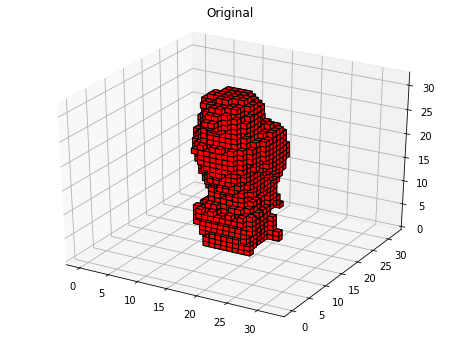

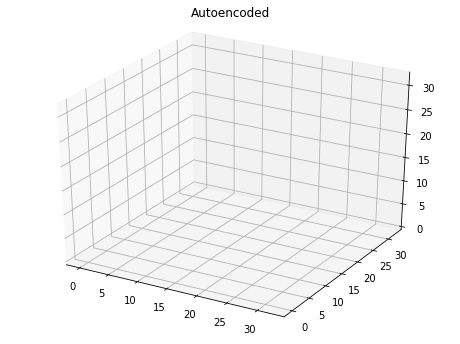

Epoch: 25, Batch: 0, Elapsed time: 3.35 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999285936355591
DEBUG_OP "min clipped_output": 3.242501770728268e-05
DEBUG_OP "mean clipped_output": 0.3549025356769562
DEBUG_OP "mean_kl": 1006.288818359375
DEBUG_OP "mean_recon": 346.2814025878906
DEBUG_OP "loss": 199.45176696777344
	KL Divergence = 1006.288818359375, Reconstruction Loss = 346.2814025878906
Epoch: 25, Batch: 1, Elapsed time: 3.36 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998212456703186
DEBUG_OP "min clipped_output": 6.094825948821381e-05
DEBUG_OP "mean clipped_output": 0.3404325544834137
DEBUG_OP "mean_kl": 931.038818359375
DEBUG_OP "mean_recon": 381.15338134765625
DEBUG_OP "loss": 211.51098

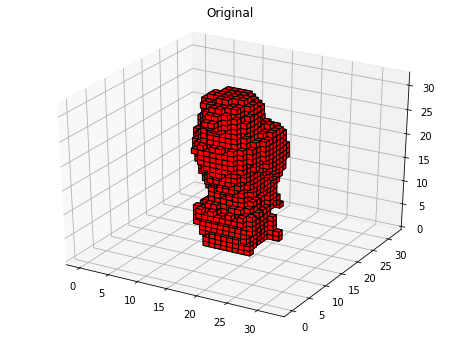

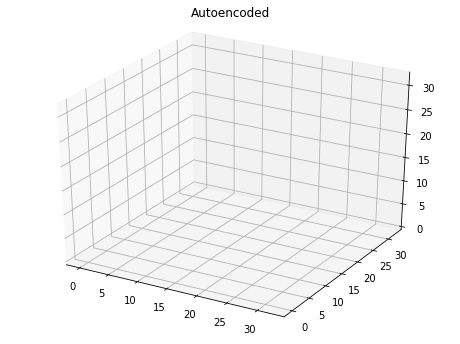

Epoch: 26, Batch: 0, Elapsed time: 3.49 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998835325241089
DEBUG_OP "min clipped_output": 3.6454785004025325e-05
DEBUG_OP "mean clipped_output": 0.35084056854248047
DEBUG_OP "mean_kl": 836.1886596679688
DEBUG_OP "mean_recon": 368.9664306640625
DEBUG_OP "loss": 201.7904815673828
	KL Divergence = 836.1886596679688, Reconstruction Loss = 368.9664306640625
Epoch: 26, Batch: 1, Elapsed time: 3.50 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998353719711304
DEBUG_OP "min clipped_output": 4.928390262648463e-05
DEBUG_OP "mean clipped_output": 0.3397172689437866
DEBUG_OP "mean_kl": 864.646728515625
DEBUG_OP "mean_recon": 389.1456298828125
DEBUG_OP "loss": 212.04074

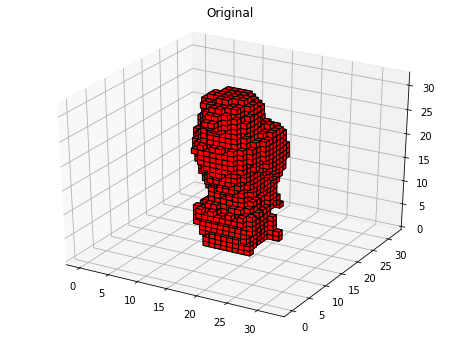

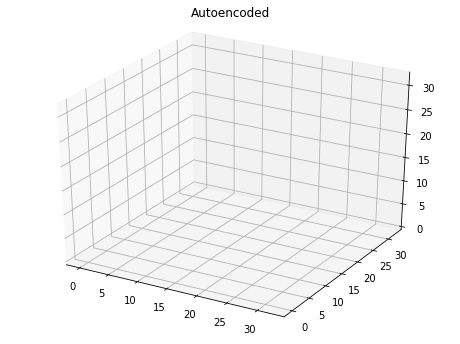

Epoch: 27, Batch: 0, Elapsed time: 3.62 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998252987861633
DEBUG_OP "min clipped_output": 3.624043529271148e-05
DEBUG_OP "mean clipped_output": 0.3505798280239105
DEBUG_OP "mean_kl": 758.462890625
DEBUG_OP "mean_recon": 362.16046142578125
DEBUG_OP "loss": 195.23631286621094
	KL Divergence = 758.462890625, Reconstruction Loss = 362.16046142578125
Epoch: 27, Batch: 1, Elapsed time: 3.63 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998691082000732
DEBUG_OP "min clipped_output": 3.925054625142366e-05
DEBUG_OP "mean clipped_output": 0.3404243290424347
DEBUG_OP "mean_kl": 800.3209838867188
DEBUG_OP "mean_recon": 393.0633544921875
DEBUG_OP "loss": 210.85569763183

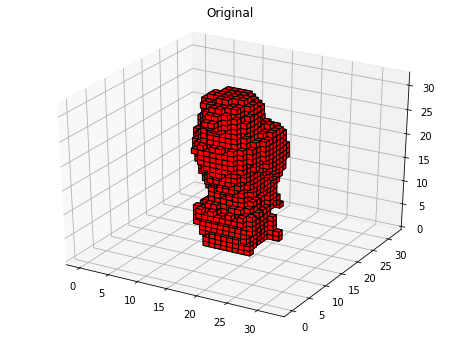

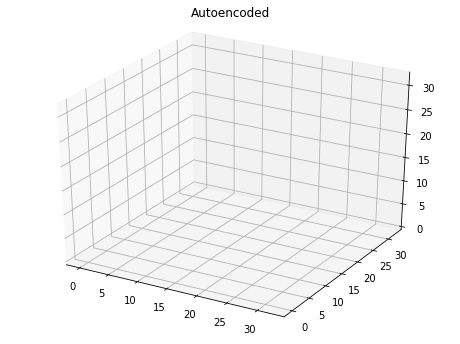

Epoch: 28, Batch: 0, Elapsed time: 3.75 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998016953468323
DEBUG_OP "min clipped_output": 3.630283390521072e-05
DEBUG_OP "mean clipped_output": 0.341336727142334
DEBUG_OP "mean_kl": 743.9235229492188
DEBUG_OP "mean_recon": 349.98663330078125
DEBUG_OP "loss": 189.17138671875
	KL Divergence = 743.9235229492188, Reconstruction Loss = 349.98663330078125
Epoch: 28, Batch: 1, Elapsed time: 3.77 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998722076416016
DEBUG_OP "min clipped_output": 3.610748171922751e-05
DEBUG_OP "mean clipped_output": 0.3296756446361542
DEBUG_OP "mean_kl": 788.4718017578125
DEBUG_OP "mean_recon": 382.15557861328125
DEBUG_OP "loss": 205.475372

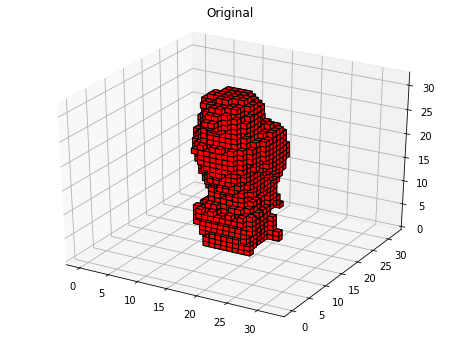

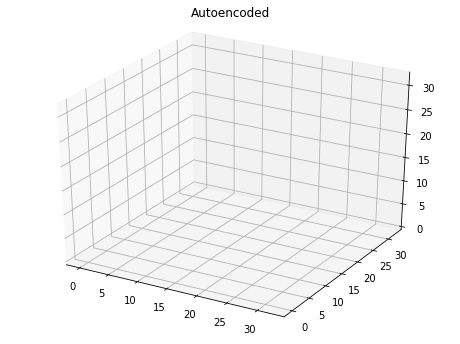

Epoch: 29, Batch: 0, Elapsed time: 3.88 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999427795410156
DEBUG_OP "min clipped_output": 1.4118954823061358e-05
DEBUG_OP "mean clipped_output": 0.34061238169670105
DEBUG_OP "mean_kl": 832.3660888671875
DEBUG_OP "mean_recon": 355.4176025390625
DEBUG_OP "loss": 195.60159301757812
	KL Divergence = 832.3660888671875, Reconstruction Loss = 355.4176025390625
Epoch: 29, Batch: 1, Elapsed time: 3.90 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998918771743774
DEBUG_OP "min clipped_output": 3.656086846604012e-05
DEBUG_OP "mean clipped_output": 0.32902011275291443
DEBUG_OP "mean_kl": 803.918212890625
DEBUG_OP "mean_recon": 372.7059326171875
DEBUG_OP "loss": 201.982

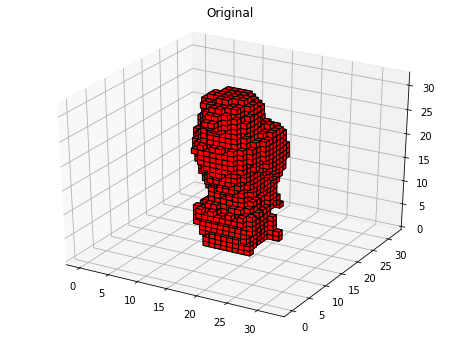

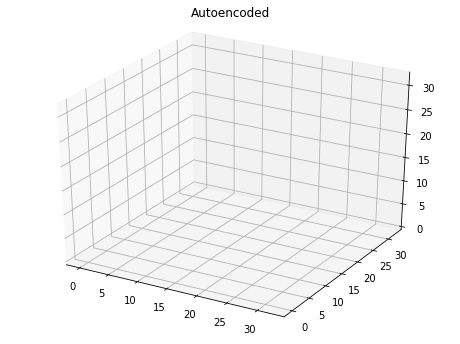

Epoch: 30, Batch: 0, Elapsed time: 4.02 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9998847246170044
DEBUG_OP "min clipped_output": 2.3202121155918576e-05
DEBUG_OP "mean clipped_output": 0.3334227502346039
DEBUG_OP "mean_kl": 805.7694091796875
DEBUG_OP "mean_recon": 345.37213134765625
DEBUG_OP "loss": 189.93399047851562
	KL Divergence = 805.7694091796875, Reconstruction Loss = 345.37213134765625
Epoch: 30, Batch: 1, Elapsed time: 4.03 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998334646224976
DEBUG_OP "min clipped_output": 3.772495256271213e-05
DEBUG_OP "mean clipped_output": 0.3243204355239868
DEBUG_OP "mean_kl": 815.0892944335938
DEBUG_OP "mean_recon": 361.9725036621094
DEBUG_OP "loss": 197.72

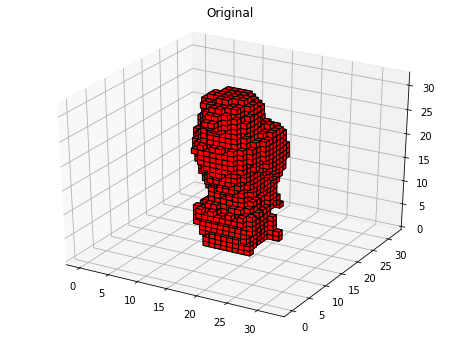

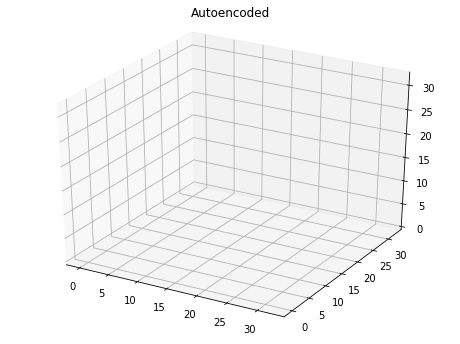

Epoch: 31, Batch: 0, Elapsed time: 4.15 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999165534973145
DEBUG_OP "min clipped_output": 1.4011219718668144e-05
DEBUG_OP "mean clipped_output": 0.33580848574638367
DEBUG_OP "mean_kl": 1008.8544921875
DEBUG_OP "mean_recon": 334.5552978515625
DEBUG_OP "loss": 194.36354064941406
	KL Divergence = 1008.8544921875, Reconstruction Loss = 334.5552978515625
Epoch: 31, Batch: 1, Elapsed time: 4.16 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998745918273926
DEBUG_OP "min clipped_output": 3.023405952262692e-05
DEBUG_OP "mean clipped_output": 0.32368946075439453
DEBUG_OP "mean_kl": 976.9017333984375
DEBUG_OP "mean_recon": 345.4461669921875
DEBUG_OP "loss": 197.745635

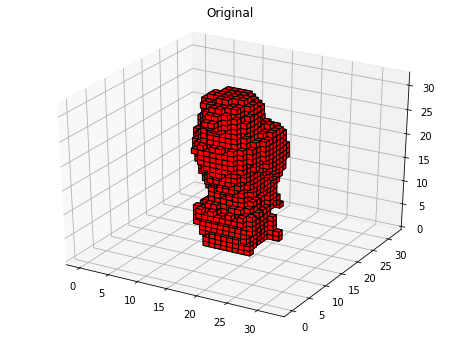

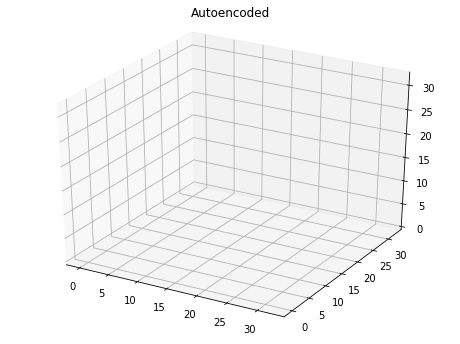

Epoch: 32, Batch: 0, Elapsed time: 4.28 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999481439590454
DEBUG_OP "min clipped_output": 1.4580751667381264e-05
DEBUG_OP "mean clipped_output": 0.33540937304496765
DEBUG_OP "mean_kl": 928.62890625
DEBUG_OP "mean_recon": 324.5273742675781
DEBUG_OP "loss": 186.26426696777344
	KL Divergence = 928.62890625, Reconstruction Loss = 324.5273742675781
Epoch: 32, Batch: 1, Elapsed time: 4.30 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998918771743774
DEBUG_OP "min clipped_output": 3.3629712561378255e-05
DEBUG_OP "mean clipped_output": 0.324924498796463
DEBUG_OP "mean_kl": 868.2313842773438
DEBUG_OP "mean_recon": 360.06268310546875
DEBUG_OP "loss": 199.294036865234

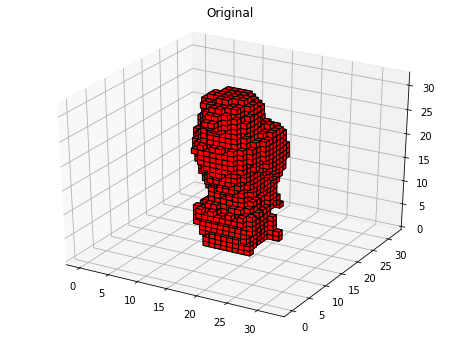

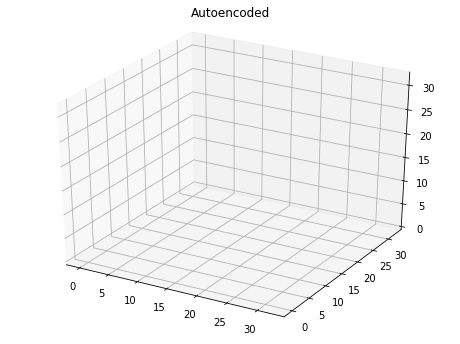

Epoch: 33, Batch: 0, Elapsed time: 4.41 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999395608901978
DEBUG_OP "min clipped_output": 1.0035069863079116e-05
DEBUG_OP "mean clipped_output": 0.3288443386554718
DEBUG_OP "mean_kl": 742.7664794921875
DEBUG_OP "mean_recon": 336.2704162597656
DEBUG_OP "loss": 183.0296173095703
	KL Divergence = 742.7664794921875, Reconstruction Loss = 336.2704162597656
Epoch: 33, Batch: 1, Elapsed time: 4.43 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999109506607056
DEBUG_OP "min clipped_output": 2.9742775950580835e-05
DEBUG_OP "mean clipped_output": 0.31616586446762085
DEBUG_OP "mean_kl": 786.5418701171875
DEBUG_OP "mean_recon": 373.05145263671875
DEBUG_OP "loss": 201.34

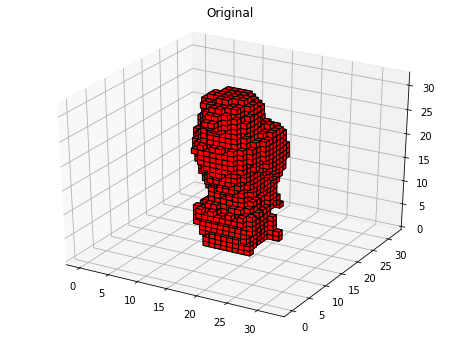

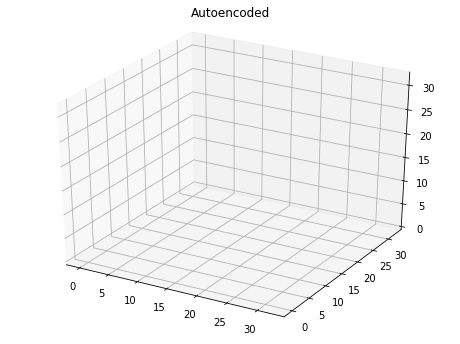

Epoch: 34, Batch: 0, Elapsed time: 4.55 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999387264251709
DEBUG_OP "min clipped_output": 2.0911800675094128e-05
DEBUG_OP "mean clipped_output": 0.32952699065208435
DEBUG_OP "mean_kl": 945.7293090820312
DEBUG_OP "mean_recon": 346.0689697265625
DEBUG_OP "loss": 196.6053009033203
	KL Divergence = 945.7293090820312, Reconstruction Loss = 346.0689697265625
Epoch: 34, Batch: 1, Elapsed time: 4.56 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999634027481079
DEBUG_OP "min clipped_output": 2.0545548977679573e-05
DEBUG_OP "mean clipped_output": 0.3179408609867096
DEBUG_OP "mean_kl": 1004.3253173828125
DEBUG_OP "mean_recon": 344.0904846191406
DEBUG_OP "loss": 198.38

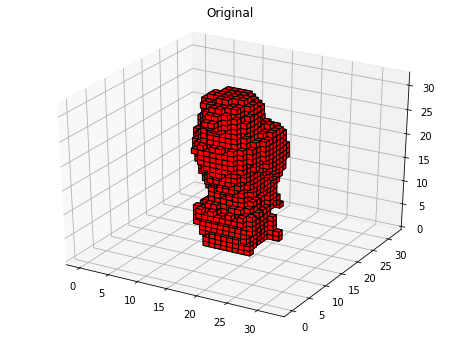

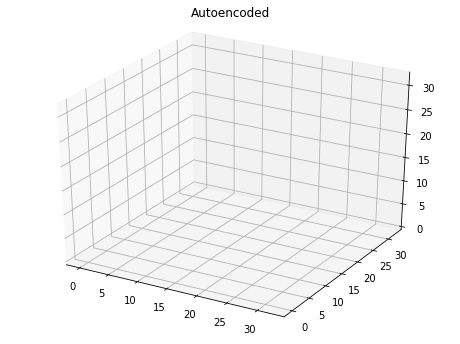

Epoch: 35, Batch: 0, Elapsed time: 4.68 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999309778213501
DEBUG_OP "min clipped_output": 1.2407224858179688e-05
DEBUG_OP "mean clipped_output": 0.3263294994831085
DEBUG_OP "mean_kl": 786.5538330078125
DEBUG_OP "mean_recon": 345.92950439453125
DEBUG_OP "loss": 189.30697631835938
	KL Divergence = 786.5538330078125, Reconstruction Loss = 345.92950439453125
Epoch: 35, Batch: 1, Elapsed time: 4.69 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.999893069267273
DEBUG_OP "min clipped_output": 2.3459722797269933e-05
DEBUG_OP "mean clipped_output": 0.31835728883743286
DEBUG_OP "mean_kl": 806.3152465820312
DEBUG_OP "mean_recon": 343.91363525390625
DEBUG_OP "loss": 189.

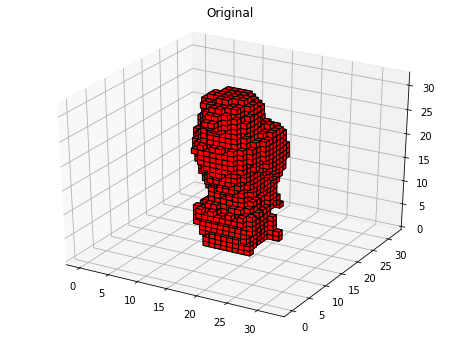

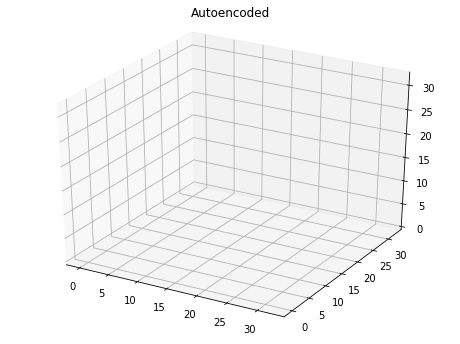

Epoch: 36, Batch: 0, Elapsed time: 4.82 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999814033508301
DEBUG_OP "min clipped_output": 9.17117631615838e-06
DEBUG_OP "mean clipped_output": 0.3213013708591461
DEBUG_OP "mean_kl": 867.4246826171875
DEBUG_OP "mean_recon": 305.260498046875
DEBUG_OP "loss": 174.93064880371094
	KL Divergence = 867.4246826171875, Reconstruction Loss = 305.260498046875
Epoch: 36, Batch: 1, Elapsed time: 4.83 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9998931884765625
DEBUG_OP "min clipped_output": 2.416735514998436e-05
DEBUG_OP "mean clipped_output": 0.3143409490585327
DEBUG_OP "mean_kl": 835.2106323242188
DEBUG_OP "mean_recon": 344.87896728515625
DEBUG_OP "loss": 191.0536804

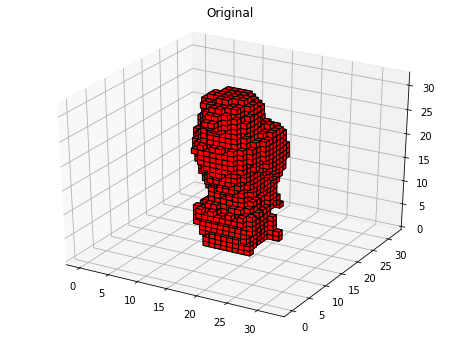

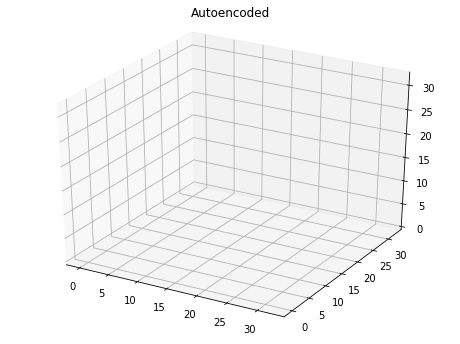

Epoch: 37, Batch: 0, Elapsed time: 4.95 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999642372131348
DEBUG_OP "min clipped_output": 1.8730406736722216e-05
DEBUG_OP "mean clipped_output": 0.32238712906837463
DEBUG_OP "mean_kl": 940.2047729492188
DEBUG_OP "mean_recon": 309.7847900390625
DEBUG_OP "loss": 180.24801635742188
	KL Divergence = 940.2047729492188, Reconstruction Loss = 309.7847900390625
Epoch: 37, Batch: 1, Elapsed time: 4.96 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999102354049683
DEBUG_OP "min clipped_output": 1.4851193554932252e-05
DEBUG_OP "mean clipped_output": 0.3137468099594116
DEBUG_OP "mean_kl": 935.1466064453125
DEBUG_OP "mean_recon": 332.0701904296875
DEBUG_OP "loss": 189.90

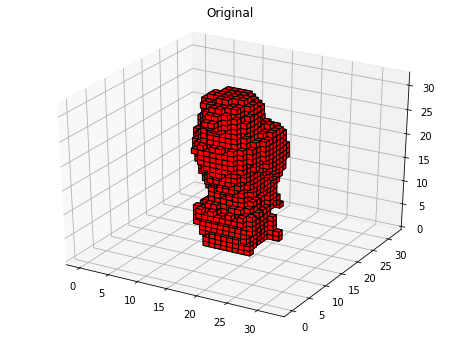

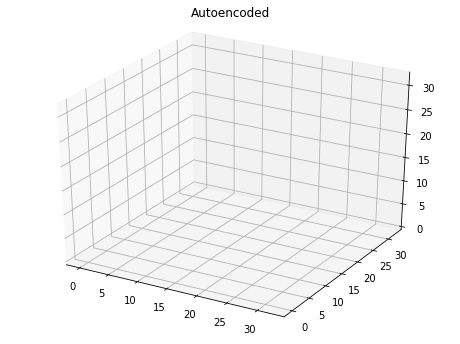

Epoch: 38, Batch: 0, Elapsed time: 5.08 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999613761901855
DEBUG_OP "min clipped_output": 5.382783911045408e-06
DEBUG_OP "mean clipped_output": 0.3196471333503723
DEBUG_OP "mean_kl": 875.715576171875
DEBUG_OP "mean_recon": 323.5714111328125
DEBUG_OP "loss": 183.43637084960938
	KL Divergence = 875.715576171875, Reconstruction Loss = 323.5714111328125
Epoch: 38, Batch: 1, Elapsed time: 5.09 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999550580978394
DEBUG_OP "min clipped_output": 1.4860629562463146e-05
DEBUG_OP "mean clipped_output": 0.30121463537216187
DEBUG_OP "mean_kl": 874.069580078125
DEBUG_OP "mean_recon": 344.72869873046875
DEBUG_OP "loss": 192.75323

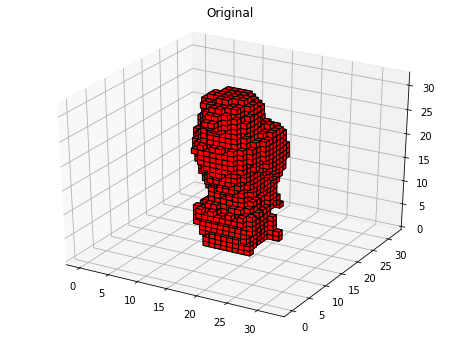

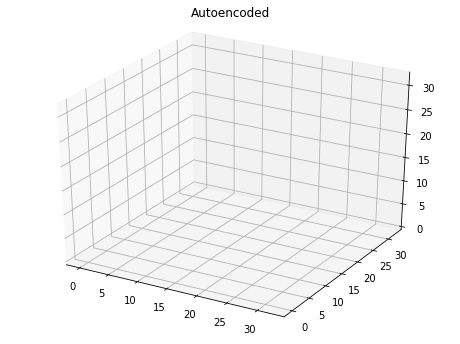

Epoch: 39, Batch: 0, Elapsed time: 5.21 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999805688858032
DEBUG_OP "min clipped_output": 7.297458068933338e-06
DEBUG_OP "mean clipped_output": 0.32192209362983704
DEBUG_OP "mean_kl": 845.4752197265625
DEBUG_OP "mean_recon": 308.9381103515625
DEBUG_OP "loss": 175.56556701660156
	KL Divergence = 845.4752197265625, Reconstruction Loss = 308.9381103515625
Epoch: 39, Batch: 1, Elapsed time: 5.23 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999045133590698
DEBUG_OP "min clipped_output": 3.501909304759465e-06
DEBUG_OP "mean clipped_output": 0.3125993311405182
DEBUG_OP "mean_kl": 829.9883422851562
DEBUG_OP "mean_recon": 339.59173583984375
DEBUG_OP "loss": 188.469

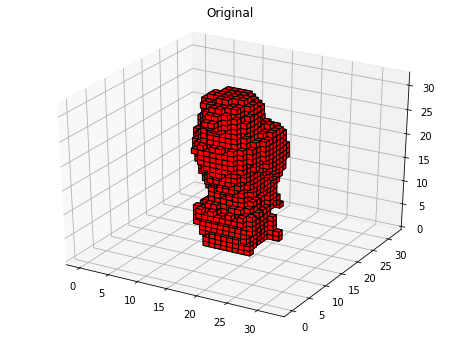

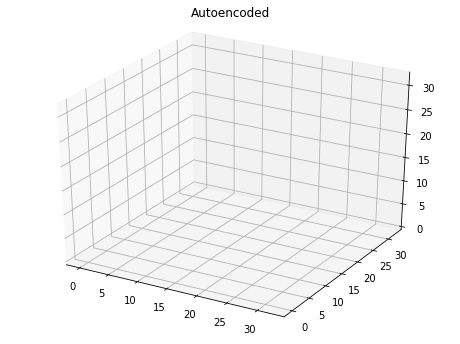

Epoch: 40, Batch: 0, Elapsed time: 5.34 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999618530273438
DEBUG_OP "min clipped_output": 5.8536065807857085e-06
DEBUG_OP "mean clipped_output": 0.3093912601470947
DEBUG_OP "mean_kl": 751.395263671875
DEBUG_OP "mean_recon": 326.2717590332031
DEBUG_OP "loss": 178.98428344726562
	KL Divergence = 751.395263671875, Reconstruction Loss = 326.2717590332031
Epoch: 40, Batch: 1, Elapsed time: 5.36 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.999955415725708
DEBUG_OP "min clipped_output": 6.9619904934370425e-06
DEBUG_OP "mean clipped_output": 0.30262404680252075
DEBUG_OP "mean_kl": 894.9876098632812
DEBUG_OP "mean_recon": 335.33465576171875
DEBUG_OP "loss": 189.5328

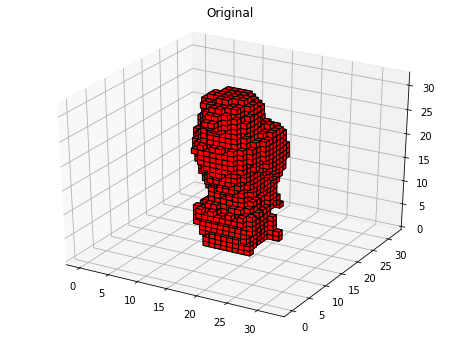

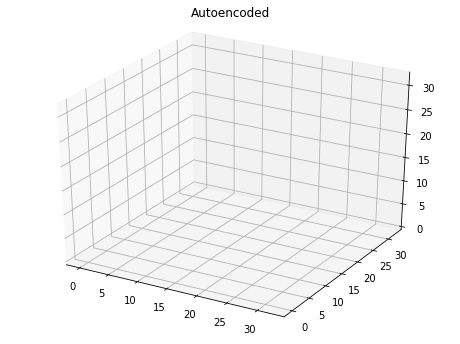

Epoch: 41, Batch: 0, Elapsed time: 5.48 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999608993530273
DEBUG_OP "min clipped_output": 8.991527465695981e-06
DEBUG_OP "mean clipped_output": 0.31339290738105774
DEBUG_OP "mean_kl": 898.3463745117188
DEBUG_OP "mean_recon": 309.560302734375
DEBUG_OP "loss": 178.2432403564453
	KL Divergence = 898.3463745117188, Reconstruction Loss = 309.560302734375
Epoch: 41, Batch: 1, Elapsed time: 5.49 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999392032623291
DEBUG_OP "min clipped_output": 9.673939530330244e-06
DEBUG_OP "mean clipped_output": 0.3080894351005554
DEBUG_OP "mean_kl": 925.2288818359375
DEBUG_OP "mean_recon": 330.80133056640625
DEBUG_OP "loss": 188.895477

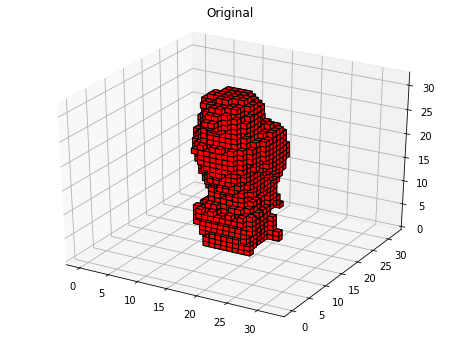

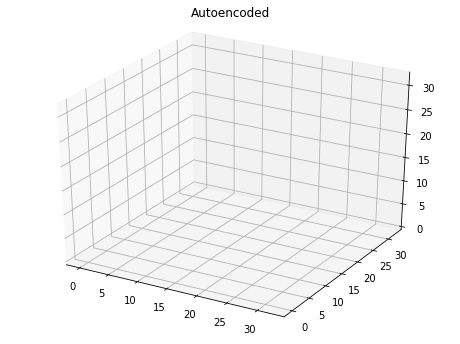

Epoch: 42, Batch: 0, Elapsed time: 5.61 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999814033508301
DEBUG_OP "min clipped_output": 7.3261380748590454e-06
DEBUG_OP "mean clipped_output": 0.3148709833621979
DEBUG_OP "mean_kl": 944.8504638671875
DEBUG_OP "mean_recon": 295.65802001953125
DEBUG_OP "loss": 174.18898010253906
	KL Divergence = 944.8504638671875, Reconstruction Loss = 295.65802001953125
Epoch: 42, Batch: 1, Elapsed time: 5.63 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999520778656006
DEBUG_OP "min clipped_output": 1.4838523384241853e-05
DEBUG_OP "mean clipped_output": 0.30672740936279297
DEBUG_OP "mean_kl": 899.4395751953125
DEBUG_OP "mean_recon": 335.3500061035156
DEBUG_OP "loss": 189.

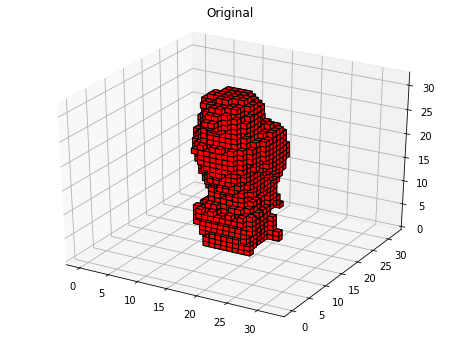

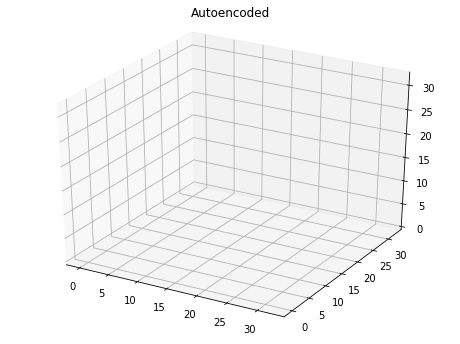

Epoch: 43, Batch: 0, Elapsed time: 5.75 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999631643295288
DEBUG_OP "min clipped_output": 4.776427431352204e-06
DEBUG_OP "mean clipped_output": 0.30902811884880066
DEBUG_OP "mean_kl": 862.7523193359375
DEBUG_OP "mean_recon": 289.347900390625
DEBUG_OP "loss": 167.654541015625
	KL Divergence = 862.7523193359375, Reconstruction Loss = 289.347900390625
Epoch: 43, Batch: 1, Elapsed time: 5.76 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999390840530396
DEBUG_OP "min clipped_output": 6.322015906334855e-06
DEBUG_OP "mean clipped_output": 0.3015395998954773
DEBUG_OP "mean_kl": 830.1005859375
DEBUG_OP "mean_recon": 345.4720458984375
DEBUG_OP "loss": 191.08393859863

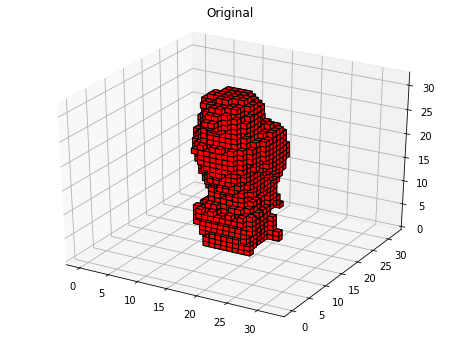

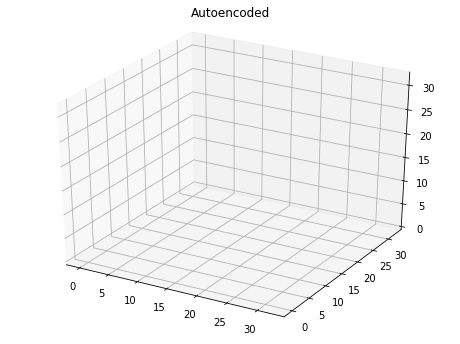

Epoch: 44, Batch: 0, Elapsed time: 5.88 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999185800552368
DEBUG_OP "min clipped_output": 1.0714192285377067e-05
DEBUG_OP "mean clipped_output": 0.3080516457557678
DEBUG_OP "mean_kl": 698.408203125
DEBUG_OP "mean_recon": 314.98138427734375
DEBUG_OP "loss": 171.5634002685547
	KL Divergence = 698.408203125, Reconstruction Loss = 314.98138427734375
Epoch: 44, Batch: 1, Elapsed time: 5.89 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999405145645142
DEBUG_OP "min clipped_output": 6.36054437563871e-06
DEBUG_OP "mean clipped_output": 0.2964770495891571
DEBUG_OP "mean_kl": 792.2932739257812
DEBUG_OP "mean_recon": 343.25262451171875
DEBUG_OP "loss": 188.38058471679

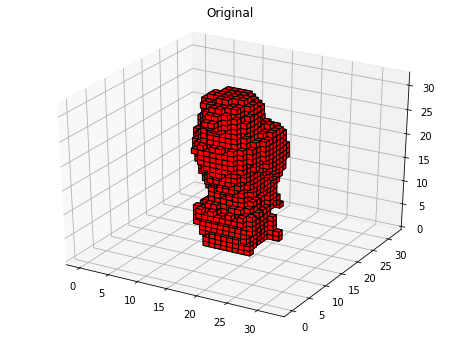

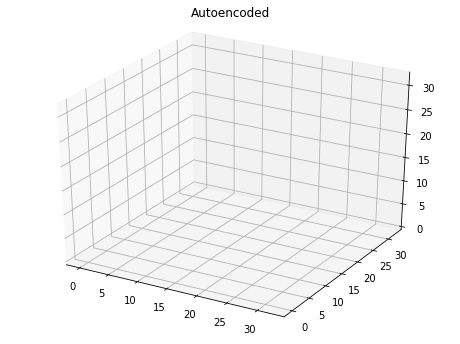

Epoch: 45, Batch: 0, Elapsed time: 6.01 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999678134918213
DEBUG_OP "min clipped_output": 6.445532108045882e-06
DEBUG_OP "mean clipped_output": 0.3052140474319458
DEBUG_OP "mean_kl": 695.9984130859375
DEBUG_OP "mean_recon": 322.58709716796875
DEBUG_OP "loss": 174.83004760742188
	KL Divergence = 695.9984130859375, Reconstruction Loss = 322.58709716796875
Epoch: 45, Batch: 1, Elapsed time: 6.03 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999567270278931
DEBUG_OP "min clipped_output": 4.092981271242024e-06
DEBUG_OP "mean clipped_output": 0.29770055413246155
DEBUG_OP "mean_kl": 937.0462646484375
DEBUG_OP "mean_recon": 333.89300537109375
DEBUG_OP "loss": 190.8

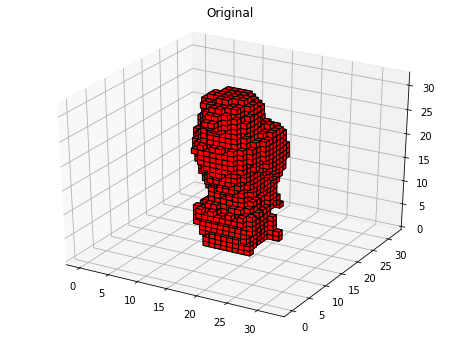

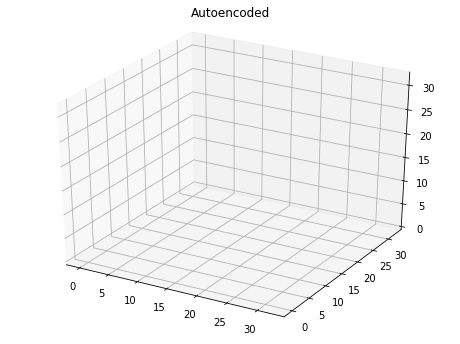

Epoch: 46, Batch: 0, Elapsed time: 6.15 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999616146087646
DEBUG_OP "min clipped_output": 5.480841991811758e-06
DEBUG_OP "mean clipped_output": 0.30569007992744446
DEBUG_OP "mean_kl": 820.0648803710938
DEBUG_OP "mean_recon": 313.6175231933594
DEBUG_OP "loss": 176.48883056640625
	KL Divergence = 820.0648803710938, Reconstruction Loss = 313.6175231933594
Epoch: 46, Batch: 1, Elapsed time: 6.16 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999573230743408
DEBUG_OP "min clipped_output": 1.1324358638375998e-05
DEBUG_OP "mean clipped_output": 0.2906843423843384
DEBUG_OP "mean_kl": 926.5770263671875
DEBUG_OP "mean_recon": 336.3619689941406
DEBUG_OP "loss": 191.424

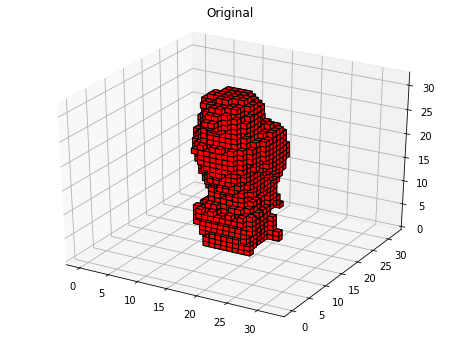

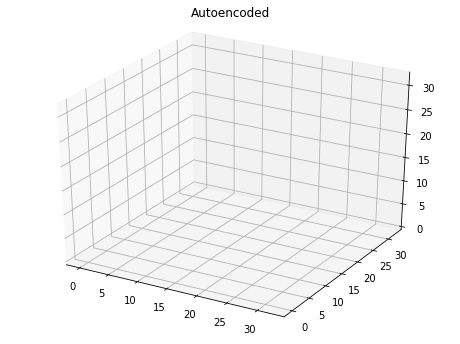

Epoch: 47, Batch: 0, Elapsed time: 6.28 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999734163284302
DEBUG_OP "min clipped_output": 8.02585873316275e-06
DEBUG_OP "mean clipped_output": 0.3009164035320282
DEBUG_OP "mean_kl": 841.812255859375
DEBUG_OP "mean_recon": 303.82989501953125
DEBUG_OP "loss": 173.13206481933594
	KL Divergence = 841.812255859375, Reconstruction Loss = 303.82989501953125
Epoch: 47, Batch: 1, Elapsed time: 6.29 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999639987945557
DEBUG_OP "min clipped_output": 8.573620107199531e-06
DEBUG_OP "mean clipped_output": 0.2932906150817871
DEBUG_OP "mean_kl": 972.342041015625
DEBUG_OP "mean_recon": 327.75787353515625
DEBUG_OP "loss": 189.686096

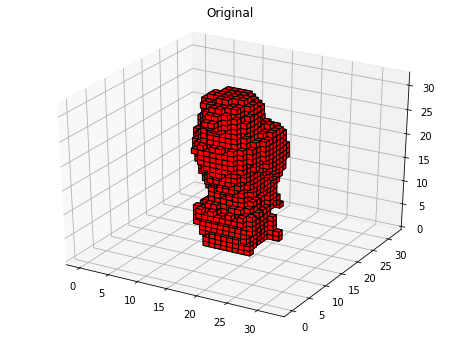

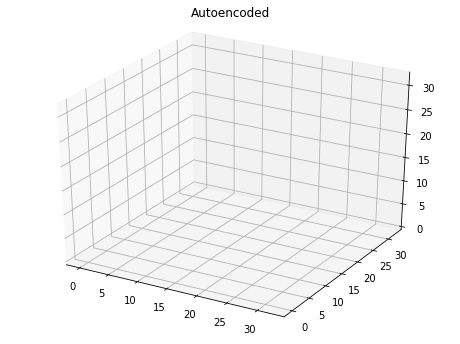

Epoch: 48, Batch: 0, Elapsed time: 6.41 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.9999696016311646
DEBUG_OP "min clipped_output": 9.35106163524324e-06
DEBUG_OP "mean clipped_output": 0.30455100536346436
DEBUG_OP "mean_kl": 771.575439453125
DEBUG_OP "mean_recon": 305.2822265625
DEBUG_OP "loss": 170.58387756347656
	KL Divergence = 771.575439453125, Reconstruction Loss = 305.2822265625
Epoch: 48, Batch: 1, Elapsed time: 6.43 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.9999434947967529
DEBUG_OP "min clipped_output": 8.863379662216175e-06
DEBUG_OP "mean clipped_output": 0.294183611869812
DEBUG_OP "mean_kl": 878.1435546875
DEBUG_OP "mean_recon": 309.28961181640625
DEBUG_OP "loss": 177.2070770263672
	K

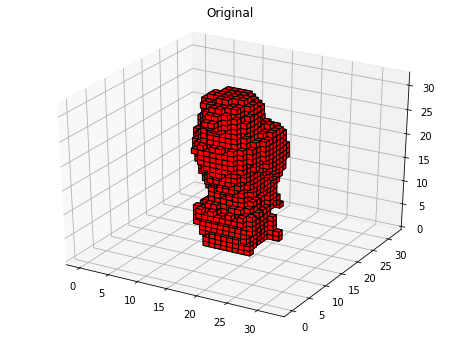

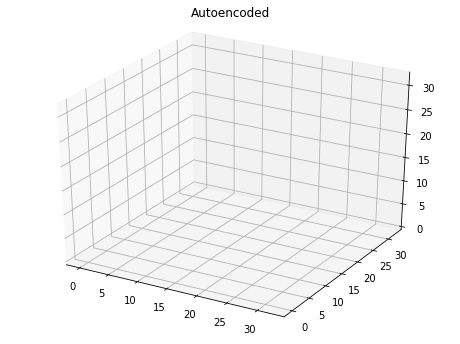

Epoch: 49, Batch: 0, Elapsed time: 6.55 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.11395540833473206
DEBUG_OP "max clipped_output": 0.999971866607666
DEBUG_OP "min clipped_output": 5.66853577765869e-06
DEBUG_OP "mean clipped_output": 0.295492023229599
DEBUG_OP "mean_kl": 722.2979736328125
DEBUG_OP "mean_recon": 308.80267333984375
DEBUG_OP "loss": 169.90660095214844
	KL Divergence = 722.2979736328125, Reconstruction Loss = 308.80267333984375
Epoch: 49, Batch: 1, Elapsed time: 6.56 mins
DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.10336165130138397
DEBUG_OP "max clipped_output": 0.999969482421875
DEBUG_OP "min clipped_output": 7.235050816234434e-06
DEBUG_OP "mean clipped_output": 0.28538867831230164
DEBUG_OP "mean_kl": 817.0980224609375
DEBUG_OP "mean_recon": 314.71661376953125
DEBUG_OP "loss": 176.84071

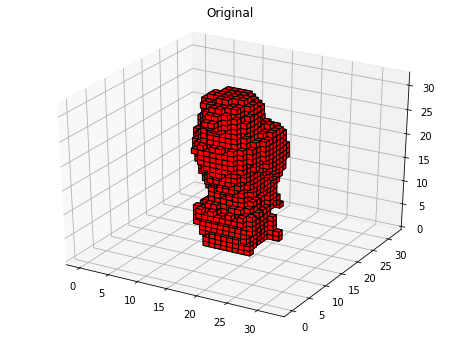

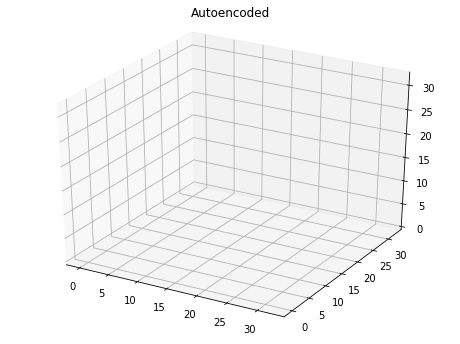

In [5]:
tf.reset_default_graph()

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=100,
                                 learning_rate=0.0001,
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1e4,
                                 verbose=True,
                                 debug=True)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=50, input_repeats=1, display_step=1, save_step=100,
             viz_data=training_example)
except Exception as exc:
    vae.close()
    raise(exc)

DEBUG_OP "max clipped_input": 0.9999998807907104
DEBUG_OP "min clipped_input": 1.0000000116860974e-07
DEBUG_OP "mean clipped_input": 0.07592776417732239
DEBUG_OP "max clipped_output": 0.18087425827980042
DEBUG_OP "min clipped_output": 0.010832071304321289
DEBUG_OP "mean clipped_output": 0.05316557362675667
DEBUG_OP "mean_kl": 24.7071533203125
DEBUG_OP "mean_recon": 182.24789428710938
DEBUG_OP "loss": 1804.471435546875


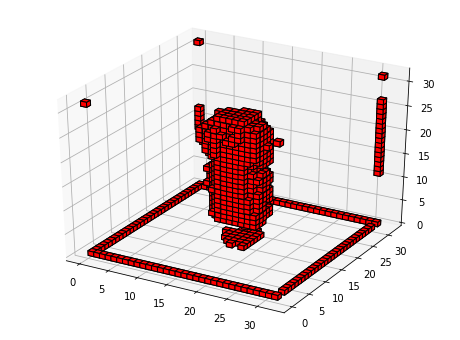

In [24]:
vox_data = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=126660),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
recon = vae.reconstruct(vox_data)
recon = np.reshape(recon, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
recon = recon > 0.10
plot_voxels(recon)